We know that early Mars had liquid water because today we observe ancient river valleys. This suggests that Mars' atmosphere use to have enough of a greenhouse effect to warm the surface temperature near ~ 273 K. Reserachers have found that a CO2 greenhouse alone can not warm Early Mars to 273 K. Reserachers have therefore considered alternative greenhouse gases. Perhaps the most plausible is a CO2 and H2 greenhouse, warmed largely by CO2-H2 collision induced absorption.

The effects of a CO2 and H2 greenhouse were first calculated accurately by [Wordsworth et al. (2017)](https://doi.org/10.1002/2016GL071766). In this notebook, we try to reproduce their calculations.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from threadpoolctl import threadpool_limits

from clima import AdiabatClimate, ClimaException
threadpool_limits(limits=4) # set number of threads

In [2]:
c = AdiabatClimate('../templates/EarlyMars/species.yaml', 
                   '../templates/EarlyMars/settings.yaml', 
                   '../templates/EarlyMars/Sun_3.8Ga.txt')
c.P_top = 1.0
c.solve_for_T_trop = True

In [3]:
print(c.species_names)

['H2O', 'CO2', 'N2', 'H2', 'CH4', 'CO', 'NH3']


Below, I show that we are working with Mars at 3.8 Ga, when the sun was 75% the Modern day brightness.

In [4]:
T_surf = 250.0
P_i = np.array([1.0e-10, 2.0, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10, 1.0e-10])*1.0e6
ISR, OLR = c.TOA_fluxes(T_surf, P_i)
total_solar_energy = 4*c.rad.wrk_sol.fdn_n[-1]/1e3 # W/m^2
solar_constant_Mars = 590 # W/m^2
print('Solar energy relative to Modern = %.3f'%(total_solar_energy/solar_constant_Mars))

Solar energy relative to Modern = 0.753


Below, I compute surface temperature on Mars for a grid of surface pressures and H2 mixing ratios, assuming a CO2 background. The goal is to reproduce the left-panel in Figure 2 of Wordsworth et al. (2017).

In [5]:
P_surf_bars = np.array([0.5, 1.0, 1.5, 2.0])
f_H2s = np.append(0.0,np.linspace(0.01,.1,10))
T_surfs = np.empty((P_surf_bars.shape[0],f_H2s.shape[0]))
bg_gas = 'CO2'
T_perturbs = [0, 2, 5, 10]

for j,P_surf_bar in enumerate(P_surf_bars):
    T_guess = 220
    P_surf = P_surf_bar*1e6
    for i,f_H2 in enumerate(f_H2s):
        print('P_surf = %.1f bar, f_H2 = %.3f'%(P_surf_bar,f_H2),end='\r')
        P_H2 = f_H2*P_surf_bar
        P_i = np.array([100.0, 1.0, 1.0e-10, P_H2, 1.0e-10, 1.0e-10, 1.0e-10])*1.0e6
        for T_perturb in T_perturbs:
            try:
                T_surf = c.surface_temperature_bg_gas(P_i, P_surf, bg_gas, T_guess = T_guess+T_perturb)
            except ClimaException as e:
                if T_perturb == T_perturbs[-1]:
                    raise ClimaException(e)
                pass
        T_surfs[j,i] = T_surf
        T_guess = T_surf

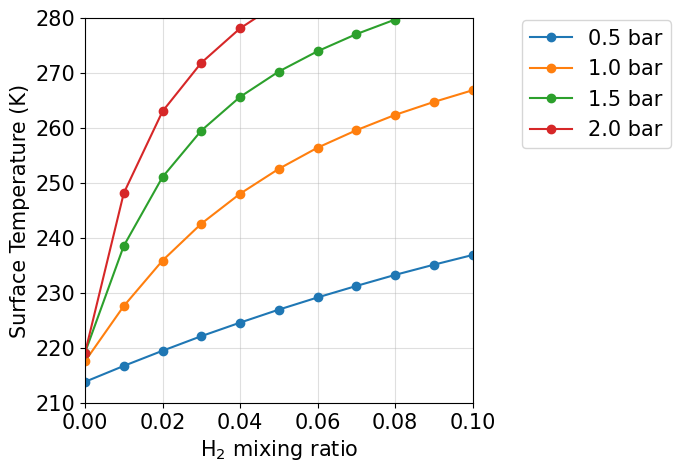

In [6]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[5,5])

for j,P_surf_bar in enumerate(P_surf_bars):
    ax.plot(f_H2s, T_surfs[j,:],ls='-', marker='o', label='%.1f bar'%P_surf_bar)
    
ax.set_ylim(210,280)
ax.set_xlim(0,.1)
ax.grid(alpha=.4)
ax.legend(ncol=1,bbox_to_anchor=(1.1, 1.02), loc='upper left')
ax.set_ylabel('Surface Temperature (K)')
ax.set_xlabel('H$_2$ mixing ratio')

plt.show()

The figure above pretty much reproduces Figure 2 (left-panel) in Wordsworth et al. (2017). `clima` finds surface temperatures a few degrees colder, which is an acceptable difference.